In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6, 7"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
import torch
from free_guidance import StableDiffusionFreeGuidancePipeline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.nn import init
from utils.guidance_functions import *
import argparse
from diffusers import LMSDiscreteScheduler, DDPMScheduler, DDIMScheduler, DPMSolverMultistepScheduler
from utils import *
from PIL import Image
torch.cuda.manual_seed_all(1234) 
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray_r'


/home/amax/.conda/envs/CVPR/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

print("Start Inference!")
# parser = argparse.ArgumentParser()
# parser.add_argument('--model_id', type=str, default="/data/zsz/models/storage_file/models/models--runwayml--stable-diffusion-v1-5/snapshots/1d0c4ebf6ff58a5caecab40fa1406526bca4b5b9")
# parser.add_argument('--seed', type=int, default=None)
# args = parser.parse_args()
# ded79e214aa69e42c24d3f5ac14b76d568679cc2
model_id = "/data/zsz/models/storage_file/models/models--runwayml--stable-diffusion-v1-5/snapshots/1d0c4ebf6ff58a5caecab40fa1406526bca4b5b9"
# model_id = "/data/zsz/models/storage_file/models/models--stabilityai--stable-diffusion-2-1/snapshots/5cae40e6a2745ae2b01ad92ae5043f95f23644d6"
device = "cuda"
pipe = StableDiffusionFreeGuidancePipeline.from_pretrained(model_id, torch_dtype=torch.float16, variant="fp16")
pipe.unet = UNetDistributedDataParallel(pipe.unet, device_ids=[0, 1], output_device=1).cuda()
# pipe.vae = UNetDistributedDataParallel(pipe.vae, device_ids=[0,1,2]).cuda()
# pipe.text_encoder = UNetDistributedDataParallel(pipe.text_encoder, device_ids=[0,1,2]).cuda()
# pipe.unet = pipe.unet.to(device)
# pipe.text_encoder = UNetDistributedDataParallel(pipe.text_encoder, device_ids=[0,1,2,3,4], output_device=3).cuda()
# pipe.unet.config, pipe.unet.dtype, pipe.unet.attn_processors, pipe.unet.set_attn_processor = pipe.unet.module.config, pipe.unet.module.dtype, pipe.unet.module.attn_processors, pipe.unet.module.set_attn_processor
# pipe.unet.config, pipe.unet.dtype = pipe.unet.module.config, pipe.unet.module.dtype
pipe.unet = pipe.unet.module
pipe = pipe.to(device)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
pipe.enable_attention_slicing()
torch.backends.cudnn.benchmark = True
    

Start Inference!


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]


Model loaded successfully!


166957


  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:30<00:00,  1.15it/s]


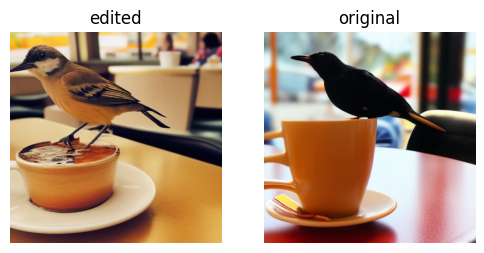

In [ ]:
# Eq(10)
seed = int(torch.rand((1,)) * 1000000)
# 642001
generator=torch.manual_seed(642001)
print(seed)
image_list = pipe(prompt="a photo of a bird drinking coffee at a diner", height=512, width=512, num_inference_steps=35, generator=generator,
        max_guidance_iter_per_step=2, guidance_func=edit_appearance, g_weight=7500)
ls = ['edit', 'ori']
for i, image in enumerate(image_list):
    image.images[0].save(f"results/{seed}_{ls[i]}.png")

show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'])

97243


  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:19<00:00,  1.83it/s]


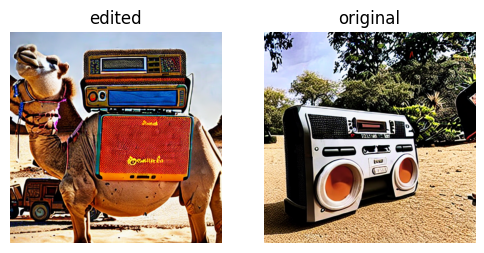

In [7]:
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
# 97243
print(seed)
guidance = partial(edit_appearance, shape_weight=1.5)
image_list = pipe(prompt="a photo of a boombox on a camel near a pond", height=512, width=512, num_inference_steps=35, generator=generator,
        max_guidance_iter_per_step=1, guidance_func=guidance, g_weight=2000)
# ls = ['edit', 'ori']
# for i, image in enumerate(image_list):
#     image.images[0].save(f"results/{seed}_{ls[i]}.png")

show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'])

80836


  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:20<00:00,  1.74it/s]


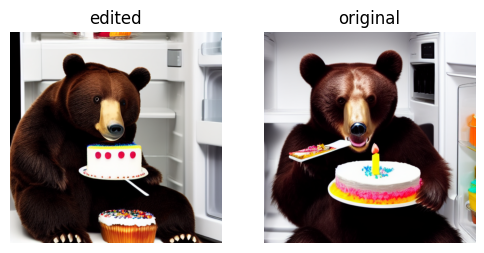

In [18]:
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
objects = ['a bear', 'birthday cake', 'a fridge']
print(seed)
# 80836
prompt="a photo of a bear eating his birthday cake near a fridge"
guidance = partial(edit_appearance, shape_weight=1.5)
image_list = pipe(prompt, objects=objects, height=512, width=512, num_inference_steps=35, generator=generator,
        max_guidance_iter_per_step=1, guidance_func=guidance, g_weight=2000)
# ls = ['edit', 'ori']
# for i, image in enumerate(image_list):
#     image.images[0].save(f"results/{seed}_{ls[i]}.png")

show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'])

78385


  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:21<00:00,  1.66it/s]


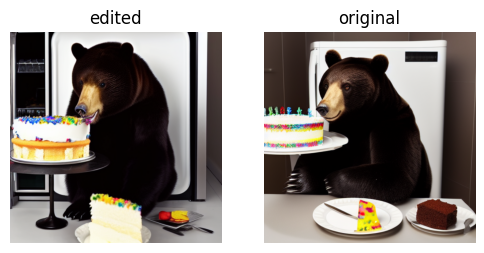

In [24]:
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
objects = ['a bear', 'a suit', 'birthday cake', 'a fridge']
print(seed)
# 78385
prompt="a photo of a bear wearing a suit eating his birthday cake near a fridge"
guidance = partial(edit_appearance, shape_weight=1.5)
image_list = pipe(prompt, objects=objects, height=512, width=512, num_inference_steps=35, generator=generator,
        max_guidance_iter_per_step=1, guidance_func=guidance, g_weight=1000)
# ls = ['edit', 'ori']
# for i, image in enumerate(image_list):
#     image.images[0].save(f"results/{seed}_{ls[i]}.png")

show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'])

19540


100%|██████████| 35/35 [00:22<00:00,  1.58it/s]


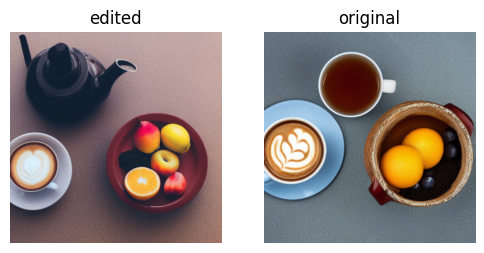

In [38]:
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
print(seed)
prompt = '“a top-down photo of a tea kettle, a bowl of fruit, and a cup of mocha'
objects = ['kettle', 'fruit', 'matcha']
guidance = partial(edit_appearance, shape_weight=2)
image_list = pipe(prompt, objects=objects, height=512, width=512, num_inference_steps=35, generator=generator,
        max_guidance_iter_per_step=1, guidance_func=guidance, g_weight=1500)
# ls = ['edit', 'ori']
# for i, image in enumerate(image_list):
#     image.images[0].save(f"results/{seed}_{ls[i]}.png")

show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'])

92384


  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:36<00:00,  1.03s/it]


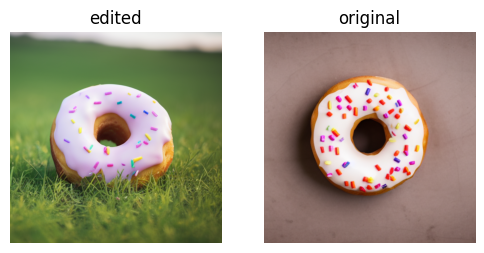

In [9]:
# Eq(13)
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
print(seed)
prompt = 'a photo of a donut on a grassy field'
ori_prompt='a photo of a donut'
objects = ['a donut']
guidance = partial(edit_layout, appearance_weight=2)
feature_layer = pipe.unet.up_blocks[-1].resnets[-2]
image_list = pipe(prompt, ori_prompt, objects=objects, height=512, width=512, num_inference_steps=35, generator=generator,
        max_guidance_iter_per_step=5, guidance_func=guidance, g_weight=1500, feature_layer=feature_layer)
# ls = ['edit', 'ori']
# for i, image in enumerate(image_list):
#     image.images[0].save(f"results/{seed}_{ls[i]}.png")

show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'])

cross_attention dimension
down_blocks：
4096 4096
1024 1024
256 256
mid：
64
up_block：
256 256 256
1024 1024 1024
4096 4096 4096
res activation
down_blocks：
layer1 (1,320,64,64)
layer2 (1,640,32,32)
layer3 (1,1280,16,16)
layer4 (1,1280,8,8)
up_block：
layer1 (1,1280,8,8)
layer2 (1,1280,16,16)
layer3 (1,640,32,32)
layer4 (1,320,64,64)

9083


  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:38<00:00,  1.09s/it]


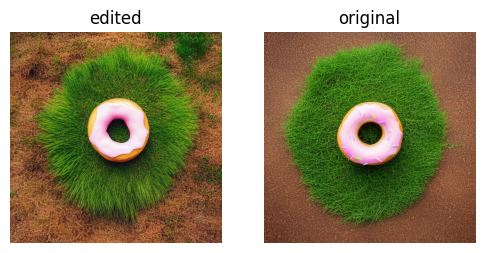

In [7]:
# Eq(13)
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
print(seed)
prompt = 'a photo of a donut on a grassy field'
# ori_prompt='a photo of a donut'
objects = ['a donut']
guidance = partial(edit_layout, appearance_weight=2)
# 64*64
feature_layer = pipe.unet.up_blocks[-1].resnets[-1]
image_list = pipe(prompt, objects=objects, height=512, width=512, num_inference_steps=35, generator=generator,
        max_guidance_iter_per_step=5, guidance_func=guidance, g_weight=3500, feature_layer=feature_layer)
# ls = ['edit', 'ori']
# for i, image in enumerate(image_list):
#     image.images[0].save(f"results/{seed}_{ls[i]}.png")

show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'])

45594


100%|██████████| 35/35 [00:36<00:00,  1.03s/it]


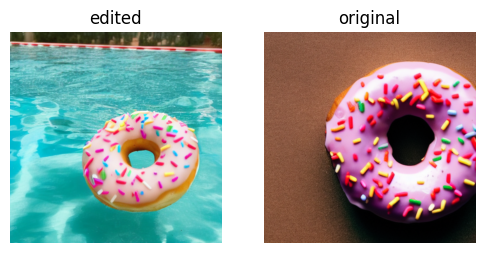

In [14]:
# Eq(13)
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
print(seed)
prompt = 'a photo of a donut falling on a swimming pool'
ori_prompt='a photo of a donut'
objects = ['a donut']
guidance = partial(edit_layout, appearance_weight=3)
# 32*32
feature_layer = pipe.unet.up_blocks[-2].resnets[-2]
image_list = pipe(prompt, ori_prompt, objects=objects, height=512, width=512, num_inference_steps=35, generator=generator,
        max_guidance_iter_per_step=5, guidance_func=guidance, g_weight=4500, feature_layer=feature_layer)
# ls = ['edit', 'ori']
# for i, image in enumerate(image_list):
#     image.images[0].save(f"results/{seed}_{ls[i]}.png")

show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'])

73302


100%|██████████| 35/35 [00:26<00:00,  1.33it/s]


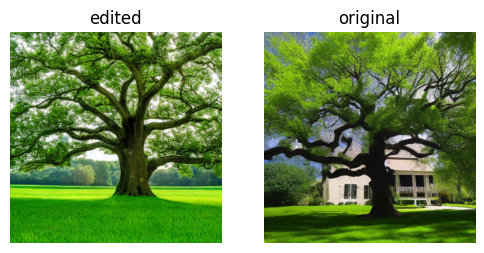

In [21]:
# Eq(13)
seed = int(torch.rand((1,)) * 100000)
# seed = 52158
generator=torch.manual_seed(seed)
print(seed)
prompt = 'a photo of an oak tree on a grass field'
objects = ['an oak tree', 'a grass field']
guidance = partial(edit_layout, appearance_weight=1.5)
feature_layer = pipe.unet.up_blocks[-1].resnets[-2]
img_path = 'tree.png'
init_latents = get_latents_from_image(pipe, img_path, device)
image_list = pipe(prompt, ori_prompt=None, objects=objects, height=512, width=512, num_inference_steps=35, 
                  generator=generator, latents=init_latents,
        max_guidance_iter_per_step=3, guidance_func=guidance, g_weight=7500, feature_layer=feature_layer)
# ls = ['edit', 'ori']
# for i, image in enumerate(image_list):
#     image.images[0].save(f"results/{seed}_{ls[i]}.png")

show_images([i for i in [image_list[0].images[0], Image.open(img_path)]], titles=['edited', 'original'], save_orig=False)

20144


100%|██████████| 35/35 [00:30<00:00,  1.16it/s]
/home/amax/.conda/envs/CVPR/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_attend_and_excite.py:463: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


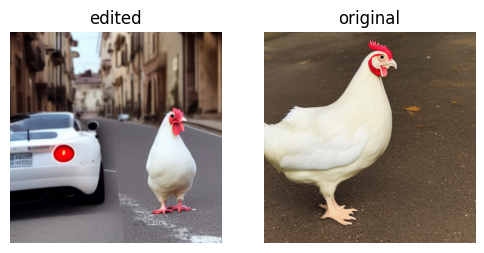

In [28]:
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(44161)
# 44161
print(seed)
prompt = 'a photo of a chicken walking across the street with an Italian sports car waiting for it'
ori_prompt='a photo of a chicken'
objects = ['chicken', 'street','Italian sports car']
guidance = partial(edit_layout, appearance_weight=2)
# 32*32
feature_layer = pipe.unet.up_blocks[-1].resnets[-2]
image_list = pipe(prompt, ori_prompt, objects=objects, height=512, width=512, num_inference_steps=35, generator=generator,
        max_guidance_iter_per_step=4, guidance_func=guidance, g_weight=7500, feature_layer=feature_layer)
# ls = ['edit', 'ori']
# for i, image in enumerate(image_list):
#     image.images[0].save(f"results/{seed}_{ls[i]}.png")

show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'], save_orig=True)

96958


100%|██████████| 35/35 [00:16<00:00,  2.16it/s]


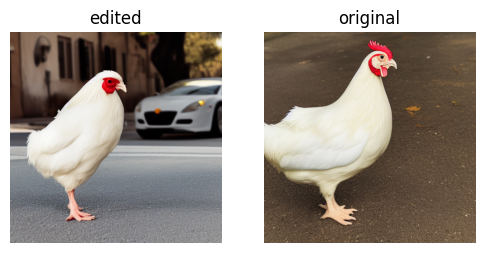

In [25]:
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(44161)
# 44161
print(seed)
prompt = 'a photo of a chicken walking across the street with an Italian sports car waiting for it'
ori_prompt='a photo of a chicken'
objects = ['chicken', 'street','Italian sports car']
guidance = partial(edit_layout, appearance_weight=2)
# 32*32
feature_layer = pipe.unet.up_blocks[-1].resnets[-2]
img_path = 'chicken.png'
init_latents = get_latents_from_image(pipe, img_path, device)
image_list = pipe(prompt, ori_prompt=ori_prompt, objects=objects, height=512, width=512, 
                  num_inference_steps=35, generator=generator, latents = init_latents,
        max_guidance_iter_per_step=1, guidance_func=guidance, g_weight=7500, feature_layer=feature_layer)
# ls = ['edit', 'ori']
# for i, image in enumerate(image_list):
#     image.images[0].save(f"results/{seed}_{ls[i]}.png")

show_images([i for i in [image_list[0].images[0], Image.open(img_path)]], titles=['edited', 'original'])

68791


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


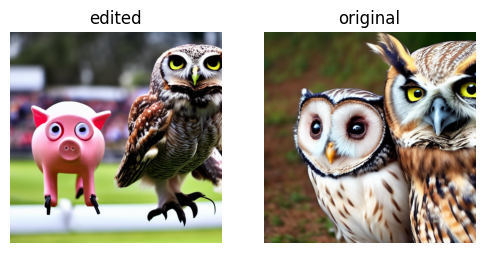

In [4]:
# Eq(13)
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
print(seed)
prompt = 'a photo of an owl and a pig running at the racetrack'
ori_prompt='a photo of an owl and a pig'
objects = ['an owl', 'a pig']
guidance = partial(edit_layout, appearance_weight=2)
# 32*32
feature_layer = pipe.unet.up_blocks[-1].resnets[-1]
image_list = pipe(prompt, ori_prompt, objects=objects, height=512, width=512, num_inference_steps=50, generator=generator,
        max_guidance_iter_per_step=4, guidance_func=guidance, g_weight=1500, feature_layer=feature_layer)
# ls = ['edit', 'ori']
# for i, image in enumerate(image_list):
#     image.images[0].save(f"results/{seed}_{ls[i]}.png")

show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'])

52529


100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


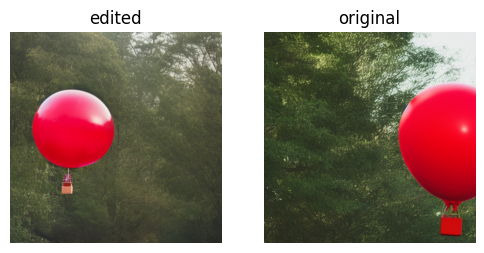

In [27]:

seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(21533)
print(seed)
prompt = 'a red balloon floating in the air'
object_to_edit = 'red balloon'
move = partial(roll_shape, direction='left', factor=0.4)
guidance = partial(move_object_by_shape, shape_weight=1, appearance_weight=1, position_weight=6, tau=move)
image_list = pipe(prompt, obj_to_edit =object_to_edit, height=512, width=512, num_inference_steps=50, generator=generator,
        max_guidance_iter_per_step=1, guidance_func=guidance, g_weight=1500)
# ls = ['edit', 'ori']
# for i, image in enumerate(image_list):
#     image.images[0].save(f"results/{seed}_{ls[i]}.png")
show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'])

21533


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


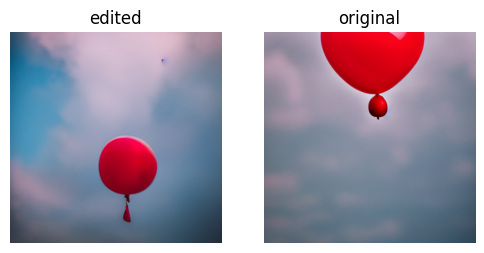

In [16]:

seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(56572)
print(seed)
prompt = 'a red balloon floating in the air'
object_to_edit = 'red balloon'
move = partial(roll_shape, direction='down', factor=0.5)
guidance = partial(move_object_by_shape, shape_weight=1, appearance_weight=1, position_weight=7, tau=move)
image_list = pipe(prompt, obj_to_edit =object_to_edit, height=512, width=512, num_inference_steps=50, generator=generator,
        max_guidance_iter_per_step=1, guidance_func=guidance, g_weight=2500)
# ls = ['edit', 'ori']
# for i, image in enumerate(image_list):
#     image.images[0].save(f"results/{seed}_{ls[i]}.png")
show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'])

98720


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


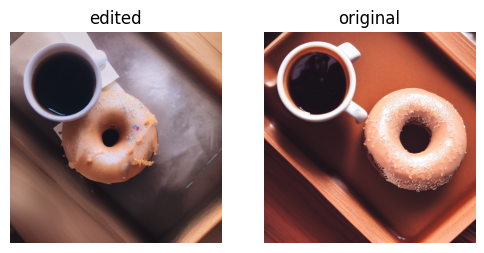

In [58]:

seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(77944)
print(seed)
prompt = 'a photo of an donut and a shot of espresso on a table'
object_to_edit = 'donut'
objects = ['donut', 'espresso']
move = partial(roll_shape, direction='left', factor=0.3)
guidance = partial(move_object_by_shape, shape_weight=1, appearance_weight=2, position_weight=6, tau=move)
img_path = 'donut.png'
init_latents = get_latents_from_image(pipe, img_path, device)
image_list = pipe(prompt, obj_to_edit = object_to_edit, height=512, width=512, 
                  num_inference_steps=50, generator=generator, 
        max_guidance_iter_per_step=1, guidance_func=guidance, g_weight=2500)
# ls = ['edit', 'ori']
# for i, image in enumerate(image_list):
#     image.images[0].save(f"results/{seed}_{ls[i]}.png")
show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'], save_orig=True)

54345


100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


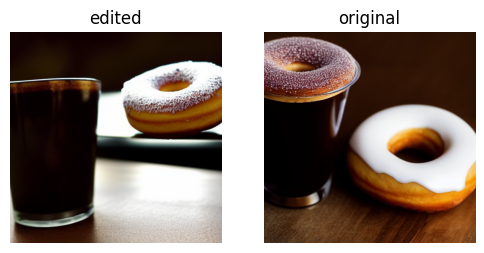

In [27]:

seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(88969)
print(seed)
prompt = 'a photo of a donut and a shot of espresso on a table'
object_to_edit = 'donut'
objects = ['donut', 'espresso']
move = partial(roll_shape, direction='up', factor=0.4)
guidance = partial(move_object_by_shape, shape_weight=0.5, appearance_weight=0.5, position_weight=6, tau=move)
img_path = 'donut.png'
init_latents = get_latents_from_image(pipe, img_path, device)
image_list = pipe(prompt, obj_to_edit = object_to_edit, height=512, width=512, 
                  num_inference_steps=50, generator=generator, latents=init_latents,
        max_guidance_iter_per_step=1, guidance_func=guidance, g_weight=1500)
# ls = ['edit', 'ori']
# for i, image in enumerate(image_list):
#     image.images[0].save(f"results/{seed}_{ls[i]}.png")
show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'], save_orig=True)

16753


100%|██████████| 50/50 [00:27<00:00,  1.79it/s]
/home/amax/.conda/envs/CVPR/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_attend_and_excite.py:463: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


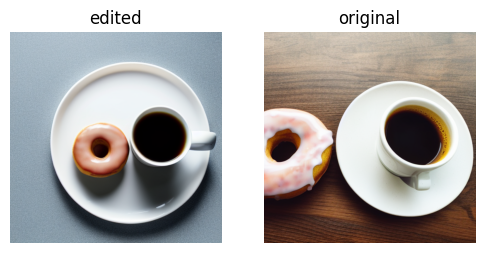

In [22]:

seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
print(seed)
prompt = 'a photo of a donut and a shot of coffee on a table'
object_to_edit = 'donut'
objects = ['donut', 'coffee']
resize = partial(resize, scale_factor=0.5)
guidance = partial(resize_object_by_shape, shape_weight=0.5, appearance_weight=0.5, size_weight=8, tau=resize)
img_path = 'coffee.png'
init_latents = get_latents_from_image(pipe, img_path, device)
image_list = pipe(prompt, obj_to_edit = object_to_edit, height=512, width=512,
                  num_inference_steps=50, generator=generator, objects = objects, latents=init_latents,
        max_guidance_iter_per_step=1, guidance_func=guidance, g_weight=500)
show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'])

30042


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


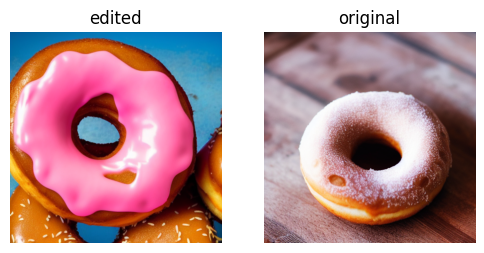

In [5]:

seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
print(seed)
prompt = 'a photo of a donut'
object_to_edit = 'donut'
# objects = ['donut', 'coffee']
resize = partial(resize, scale_factor=2)
guidance = partial(resize_object_by_shape, shape_weight=0.5, appearance_weight=0.5, size_weight=10, tau=resize)
# img_path = 'coffee.png'
# init_latents = get_latents_from_image(pipe, img_path, device)
image_list = pipe(prompt, obj_to_edit = object_to_edit, height=512, width=512,
                  num_inference_steps=50, generator=generator,
        max_guidance_iter_per_step=1, guidance_func=guidance, g_weight=500)
show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'])